## Load colmap data

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import numpy as np
import os
import cv2

from utils.colmap.read_database import COLMAPDataLoader, extract_all_pair_pts
from utils.datasets.data_parsing import parse_abs_pose_txt, parse_matching_pairs
from utils.datasets.camera_intrinsics import get_camera_intrinsic_loader
from utils.common.plotting import plot_matches

"""
# 7Scenes: 'heads', 'chess', 'fire', 'office', 'pumpkin', 'redkitchen', 'stairs'
# CambridgeLandmarks: 'ShopFacade', 'KingsCollege', 'StMarysChurch', 'OldHospital'
"""
scene = 'ShopFacade'
dataset = 'CambridgeLandmarks'
colmap_db_dir = os.path.join('../data/colmap_dbs/', dataset)
dataset_dir =  os.path.join('../data/datasets_original', dataset)
pair_gt = 'test_pairs.5nn.300cm50m.vlad.minmax.txt'
intrinsic_loader = get_camera_intrinsic_loader(dataset_dir, dataset, scene)

# Load colmap data
database_path = os.path.join(colmap_db_dir, scene, 'database.db')
db_loader = COLMAPDataLoader(database_path)
# matches = db.load_matches()
key_points = db_loader.load_keypoints(key_len=6)
images = db_loader.load_images(name_based=True)           
        
# Load data pairs
gt_dir = os.path.join(dataset_dir, scene)
pair_txt = os.path.join(gt_dir, pair_gt)
im_pairs = parse_matching_pairs(pair_txt) # (im1, im2) : (q, t, ess_mat)
total_num = len(im_pairs)

# Prepare correspondences
pair_names = list(im_pairs.keys())
pair_ids = [(images[im1][0], images[im2][0]) for im1, im2 in pair_names]
matches = db_loader.load_pair_matches(pair_ids)
corrd_dict, invalid = extract_all_pair_pts(pair_ids, key_points, matches)
print('Dataset {} total pairs: {} loaded pairs without correspondences: {}'.format(scene, total_num, len(invalid)))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading focals scene: ShopFacade cameras: 334
Load keypoints to dataloader
Load images to dataloader
Load matches to dataloader
Dataset ShopFacade total pairs: 515 loaded pairs without correspondences: 1


## Visualize correspondences

Plotting inliers:  100


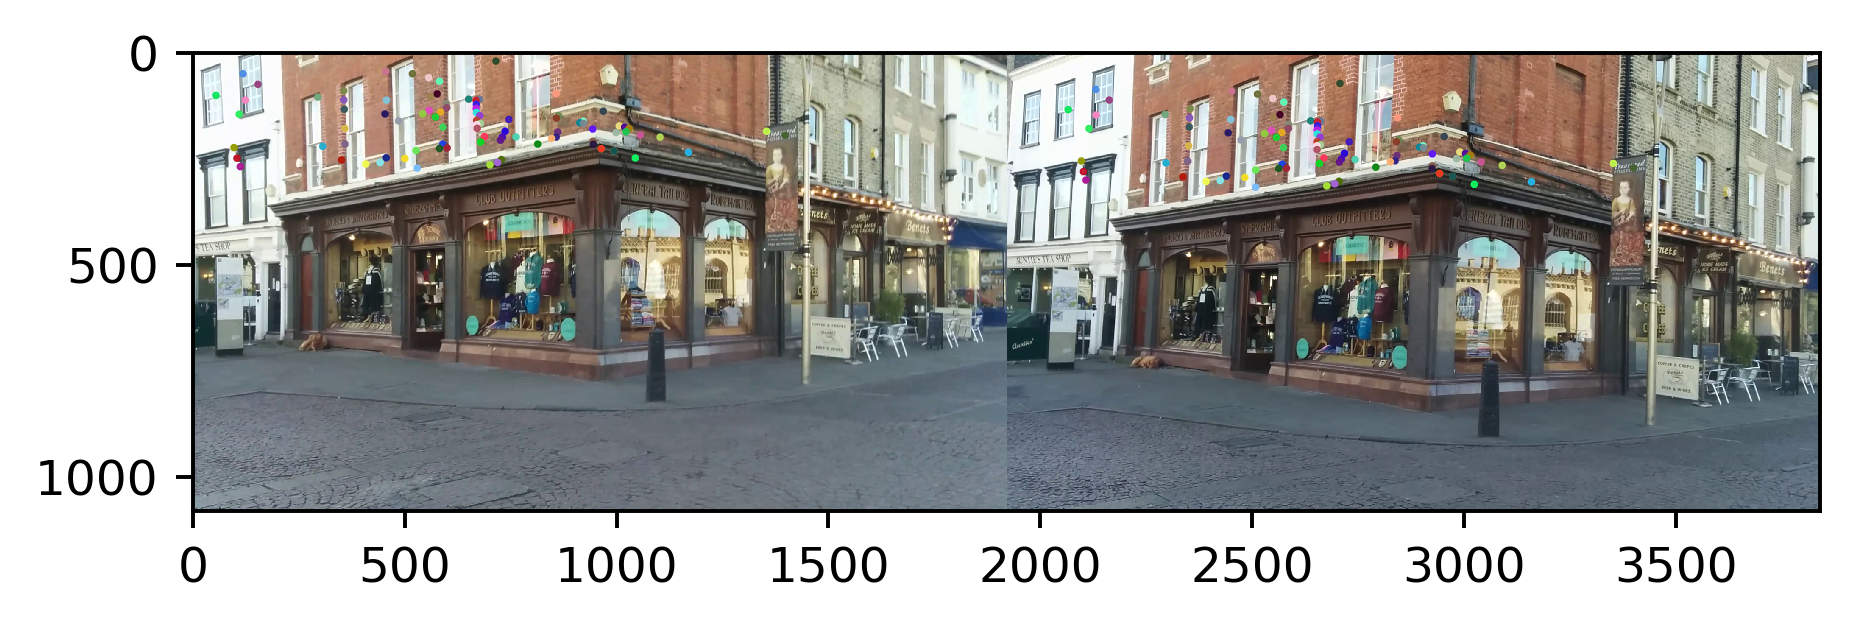

Plotting inliers:  100


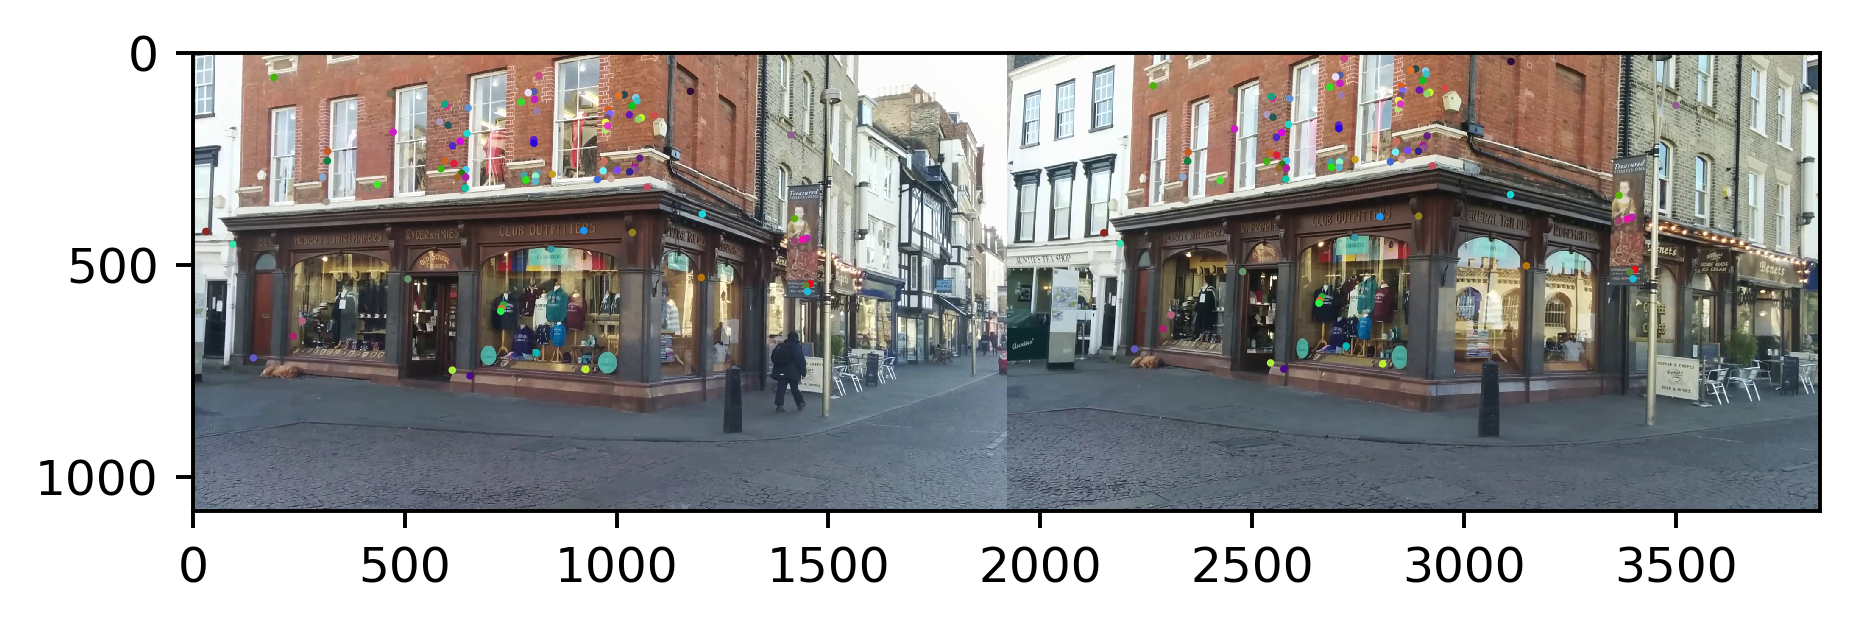

In [5]:
# Plot samples
with_inliers = True
for i, (train_im, test_im) in enumerate(pair_names):
    assert (images[train_im][0], images[test_im][0]) == pair_ids[i]  #DEBUG
    if i in invalid:
        continue   # Skip pairs without correspondences    
 
    # Extract essential matrix from correspondences
    correspondences = corrd_dict[pair_ids[i]]
    if with_inliers:
        # Prepare camera intrinsic matrix
        K = intrinsic_loader.get_relative_intrinsic_matrix(train_im, test_im)
        # Estimate essential matrix from correspondences and extract relative poses
        p1 = correspondences[:, 0:2]
        p2 = correspondences[:, 2:4]
        E, inliers = cv2.findEssentialMat(p1, p2, cameraMatrix=K, method=cv2.FM_RANSAC)
        inliers = np.where(inliers.squeeze() == 1)[0]
    plot_matches(os.path.join(gt_dir, train_im), os.path.join(gt_dir, test_im), correspondences, 
                 Npts=100, inliers=inliers, lines=False)
    if i >= 1:
        break
